In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from absl import logging
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageOps
from scipy.spatial import cKDTree
from skimage.feature import plot_matches
from skimage.measure import ransac
from skimage.transform import AffineTransform
from six import BytesIO
import tensorflow as tf
import tensorflow_hub as hub
from six.moves.urllib.request import urlopen
from skimage import io



In [ ]:
image1 = io.imread('https://upload.wikimedia.org/wikipedia/commons/2/28/Bridge_of_Sighs%2C_Oxford.jpg') 
image2 = io.imread('https://upload.wikimedia.org/wikipedia/commons/c/c3/The_Bridge_of_Sighs_and_Sheldonian_Theatre%2C_Oxford.jpg')

In [ ]:
image1 = io.imread('/content/drive/MyDrive/Datasets/satellite_data/desert/desert(1).jpg') 
image2 = io.imread('/content/drive/MyDrive/Datasets/satellite_data/desert/desert(100).jpg')

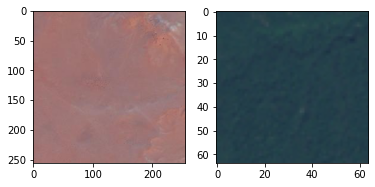

In [ ]:
#original
plt.subplot(1,2,1)
plt.imshow(image1)
plt.subplot(1,2,2)
plt.imshow(image2)

In [ ]:
IMAGE_1_URL = '/content/drive/MyDrive/Datasets/WhatsApp Image 2023-01-17 at 2.22.15 PM (1).jpeg'
IMAGE_2_URL = '/content/drive/MyDrive/Datasets/WhatsApp Image 2023-01-17 at 2.22.15 PM.jpeg'

In [ ]:
def download_and_resize(name, url, new_width=256, new_height=256):
    # path = tf.keras.utils.get_file(url.split('/')[-1], url)
    image = Image.open(url)
    image = ImageOps.fit(image, (new_width, new_height),Image.ANTIALIAS)
    return image

image1 = download_and_resize('image_1.jpg', IMAGE_1_URL)
image2 = download_and_resize('image_2.jpg', IMAGE_2_URL)

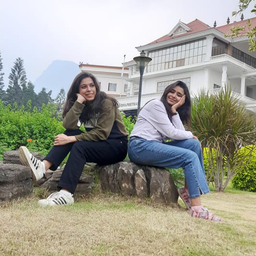

In [ ]:
image2

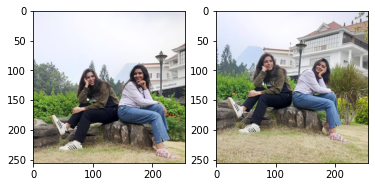

In [ ]:
plt.subplot(1,2,1)
plt.imshow(image1)
plt.subplot(1,2,2)
plt.imshow(image2)

In [ ]:
delf=hub.load('https://tfhub.dev/google/delf/1').signatures['default']

In [ ]:
def run_delf(image):
    np_image = np.array(image)
    float_image = tf.image.convert_image_dtype(np_image, tf.float32)
    return delf(image=float_image , score_threshold =tf.constant(100.0), image_scales=tf.constant([0.25, 0.3536, 0.5, 0.7071, 1.0, 1.4142, 2.0]), max_feature_num=tf.constant(1000))
result1 = run_delf(image1)
result2 = run_delf(image2)


Loaded image 1's 100 features
Loaded image 2’s 135 features
Found 43 inliers


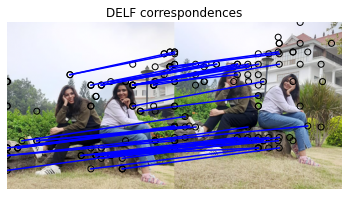

In [ ]:
def match_images(image1, image2, result1, result2):
    distance_threshold = 0.8
    # Read features.
    num_features_1 = result1['locations'].shape[0]
    print("Loaded image 1's %d features" % num_features_1)
    num_features_2 = result2['locations'].shape[0]
    print("Loaded image 2’s %d features" % num_features_2)
    # Find nearest-neighbor matches using a KD tree.
    d1_tree = cKDTree(result1['descriptors'])
    _, indices = d1_tree.query(result2['descriptors'], distance_upper_bound=distance_threshold)
    # Select feature locations for putative matches.
    locations_2_to_use = np.array([
      result2['locations'][i,]
    for i in range(num_features_2)
    if indices[i] != num_features_1
    ])
    locations_1_to_use = np.array([
      result1['locations'][indices[i],]
      for i in range(num_features_2)
      if indices[i] != num_features_1
    ])
# Perform geometric verification using RANSAC.
    _, inliers = ransac(
      (locations_1_to_use, locations_2_to_use),
      AffineTransform,
      min_samples=3,
      residual_threshold=20,
      max_trials=1000)
    print('Found %d inliers' % sum(inliers))
    # Visualize correspondences.
    _, ax = plt.subplots()
    inlier_idxs = np.nonzero(inliers)[0]
    plot_matches(
      ax,
      image1,
      image2,
      locations_1_to_use,
      locations_2_to_use,
      np.column_stack((inlier_idxs, inlier_idxs)),
      matches_color='b')
    ax.axis('off')
    ax.set_title('DELF correspondences')

match_images(image1, image2, result1, result2)